# Support Vector Machine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Загрузка, предварительный анализ данных
Сперва загрузим исследуемый набор данных

In [2]:
data = pd.read_csv('svm-data.csv')
data

,feature_1,feature_2,target
0,11.121540,6.281423,-1
1,8.386830,-3.210270,-1
2,9.973580,10.733533,1
3,11.371653,14.571764,1
4,9.086244,8.579827,1
...,...,...,...
295,11.133565,14.085502,1
296,11.622685,9.397473,-1
297,10.399098,11.762470,1
298,11.243594,6.569158,-1


In [3]:
data.shape

(300, 3)

В наборе присутствует 300 объектов, каждый из которых имеет два признака и одно значение целевой переменной. Перед нами задача классификации, поскольку мы должны прогнозировать метку из $\{-1,1\}$.

Переобозначим признаки за $X$, а таргет за $y$.

In [4]:
X = data.iloc[:, :-1].values
y = data['target'].values

Поскольку мы имеем дело с данными в $\mathbb R^2$, то их можно визуализировать.

> Почему в $\mathbb R^2$?

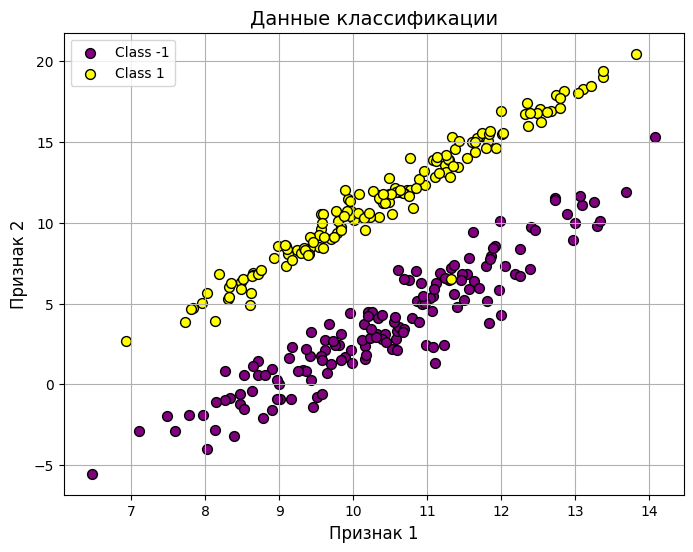

In [5]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X[y == -1][:, 0], X[y == -1][:, 1], c='purple', edgecolor='k', s=50, label='Class -1', 
)

scatter = plt.scatter(
    X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', edgecolor='k', s=50, label='Class 1',    
)

plt.title("Данные классификации", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Заметим, что объекты линейно разделимы по классам. То есть это не вызовет проблем для модели логистической регрессии

## Построение модели логистической регрессии

Разделим выборку на обучающую и тестовую по методу отложенной выборки. На тест выделим $25\%$.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Основные формулы модели:
- эмпирический риск (совпадает с метрикой accuracy) $$ L(x;w) = \dfrac 1 n\sum\limits_{i=0}^n [f(x_i; w) \ne y_i];$$
- отступ классификатора $$M_i(w, w_0) = \big( (x,w) - w_0\big)\cdot y_i;$$
- задача минимизации Hinge Loss $$\mathcal L(x;w,w_0) = \sum\limits_{i=1}^n \big(1-M_i(w,w_0)\big)_+ + \dfrac{1}{2C}||w||^2 \to \underset{w, w_0}\min,$$
- градиент функционала потерь $$\dfrac{\partial \mathcal L(x;w)}{\partial w} = \sum\limits_{i=1}^n\begin{cases}0,\ 1-y_i(w_i, x) \leq 0,\\ -y_ix_i,\ 1-y_i(w_i, x) > 0\end{cases} + \dfrac{1}{C}w.$$

Сперва приведем реализацию эмпирического риска

In [7]:
def accuracy(targets, predictions):
    return np.equal(targets, predictions).mean()

Определим функцию для вычисления лосса

Для обучения модели будем использовать градиентный спуск. Градиентный спуск определим следующим образом:
$$w^{(k+1)} = w^{(k)} -\alpha \cdot \dfrac{\partial \mathcal L}{\partial w^{(k)}},\ k=0,1,\ldots,$$
где $\alpha$ -- это шаг обучения. Мы будем считать $\alpha = 0.001$. 

Запрограммируем модель сразу в виде класса

In [15]:
class SVM:
    # Конструктор класса
    def __init__(self, lr=0.001, C=100, n_iterations=1000):
        self.lr = lr
        self.C = C
        self.n_iterations = n_iterations
        
        self.losses = []
        self.w = None
        self.b = None

    # Вычисление лосса
    def hinge_loss(self, X, y):
        margins = 1 - y * (np.dot(X, self.w) - self.b)
        losses = np.maximum(0, margins)
        loss = np.mean(losses) + 1/2 * self.C**(-1) * np.sum(self.w**2)
        return loss
    
    def fit(self, X, y):
        # Проверяем y in {-1,1}
        assert set(np.unique(y)).issubset({-1, 1}), "Only binary classification is supported"
        
        n_samples, n_features = X.shape

        # Инициализируем параметры нулями
        self.w = np.zeros(n_features) if self.w is None else self.w
        self.b = 0 if self.b is None else self.b

        # Цикл для шагов градиентного спуска
        for _ in range(self.n_iterations):

            # Корректируем веса отдельно для каждого объекта
            for i in range(n_samples):
                # Вычисление отступа по соответствующей формуле
                margin = y[i] * (np.dot(X[i], self.w) - self.b)

                # Шаг градиентного спуска
                if margin >= 1:
                    self.w -= self.lr * (self.C**(-1) * self.w)
                else:
                    self.w -= self.lr * (self.C**(-1) * self.w - X[i] * y[i])
                    self.b -= self.lr * y[i]

            # Записываем текущее значение Hinge Loss
            self.losses.append(self.hinge_loss(X,y))

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

Создадим объект класса модели и обучим ее

In [38]:
svm = SVM()
svm.fit(X_train, y_train)
losses = svm.losses

Выведем график лосса, чтобы убедиться в правильности работы алгоритма

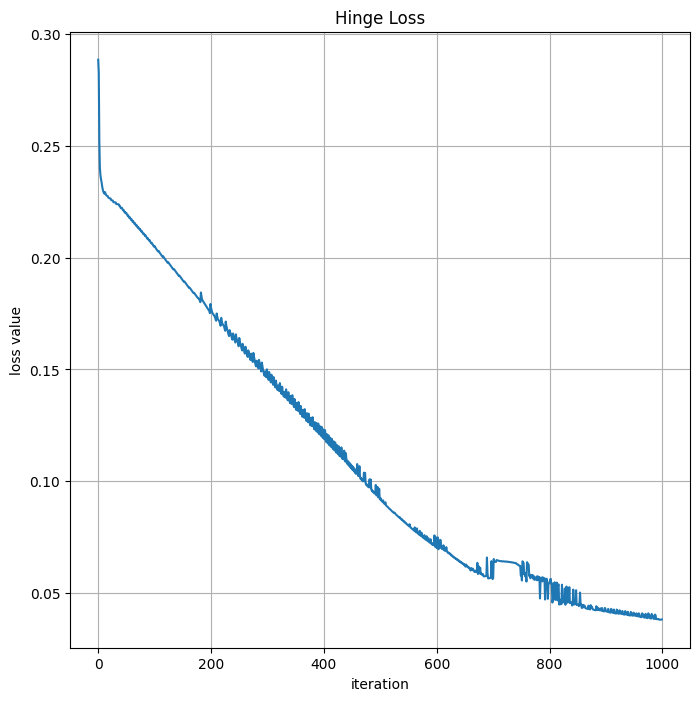

In [39]:
plt.figure(figsize=(8, 8))
plt.title('Hinge Loss')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.plot(losses)
plt.grid(True)
plt.show()

Изобразим графически разделяющую плоскость модели на обучающей выборке

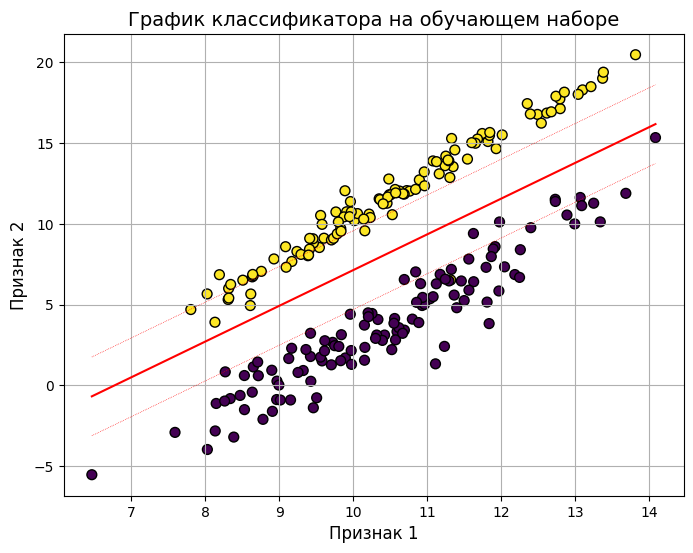

In [40]:
w = svm.w
b = svm.b

x_disp = np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=10)

y = lambda x: -(x * w[0] - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.figure(figsize=(8, 6))
plt.plot(x_disp, y_disp, 'red', label='SVM')

y = lambda x: -(x * w[0] - 1 - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.plot(x_disp, y_disp, 'red', label='edge', linestyle=':', linewidth=0.5)

y = lambda x: -(x * w[0] + 1 - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.plot(x_disp, y_disp, 'red', label='edge', linestyle=':', linewidth=0.5)

y = data['target'].values

plt.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', s=50,
)

plt.title("График классификатора на обучающем наборе", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.grid(True)
plt.show()

Вычислим значение эмпирического риска на обучающей выборке (хотя видно, что должно быть равно 1)

In [19]:
y_hat = svm.predict(X_train)

accuracy(y_hat, y_train)

0.9955555555555555

Рассмотрим результат работы модели на тестовой выборке

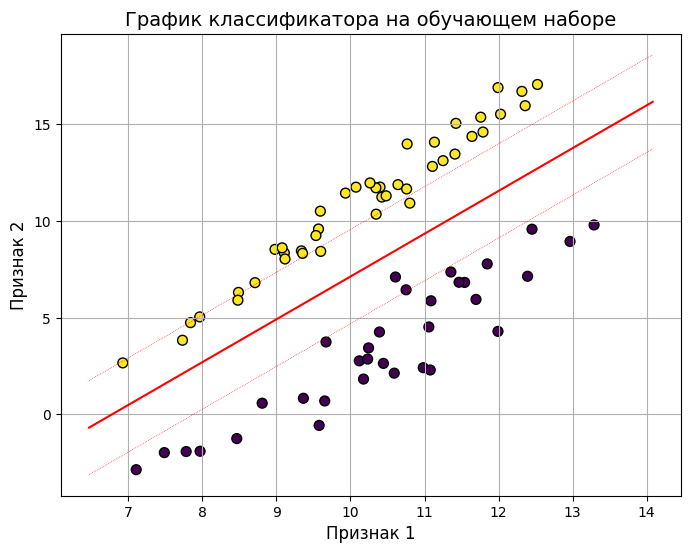

In [20]:
x_disp = np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=10)

y = lambda x: -(x * w[0] - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.figure(figsize=(8, 6))
plt.plot(x_disp, y_disp, 'red', label='SVM')

y = lambda x: -(x * w[0] - 1 - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.plot(x_disp, y_disp, 'red', label='edge', linestyle=':', linewidth=0.5)

y = lambda x: -(x * w[0] + 1 - b) / w[1]
y_disp = [y(x) for x in x_disp]

plt.plot(x_disp, y_disp, 'red', label='edge', linestyle=':', linewidth=0.5)


plt.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', s=50,
)

plt.title("График классификатора на обучающем наборе", fontsize=14)
plt.xlabel("Признак 1", fontsize=12)
plt.ylabel("Признак 2", fontsize=12)
plt.grid(True)
plt.show()

In [21]:
y_pred = svm.predict(X_test)

accuracy(y_pred, y_test)

1.0

В данном случае модель корректно отрабатывает на данных.